In [32]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans



In [72]:

batch_size = 50
take_latent_max =20
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim=10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.0
beta_start = beta
beta_end = 5.0
total_step = 500
beta_delta = (beta_end-beta_start)/total_step

save_folder = 'SGD-alpha-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

alpha_0 = 10.

mu_c_focus = 0.5

In [73]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [74]:
def initialize_centers():

    mu_c = mu_c_focus*torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    log_N_k = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c, log_N_k

In [75]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,log_N_k_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,log_N_k_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [76]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
log_N_k_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [77]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,log_N_k_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [78]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,log_N_k_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [79]:

def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [80]:
def gauss(mus,logvars,mu_c,logvar_c,log_N_k,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())
            log_pi_k = torch.digamma(alpha_0 + log_N_k.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k.exp().sum(2,keepdim = True))

            gamma_c = ((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp())/(((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = ((((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [81]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()


In [82]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [83]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,log_N_k_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -((((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))+torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True))).exp()).sum(2,keepdim=True)).log()).sum() + ((log_N_k_f.exp())*(torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True)))).sum(2).squeeze() + torch.lgamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2).squeeze()) - (torch.lgamma(alpha_0 + log_N_k_f.exp())).sum(2).squeeze()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [84]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_c_f=logvar_c_g,log_N_k_f=log_N_k_g)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [85]:
def test_c(epoch,mu_c,logvar_c,log_N_k):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,log_N_k_f=log_N_k).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [86]:
def train_c_epoch(epochs,mu_c,logvar_c,log_N_k):
    for epoch in range(1, epochs +1):
        train_c(epoch)
        test_c(epoch,mu_c,logvar_c,log_N_k)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [87]:
mu_c_g,logvar_c_g,log_N_k_g

(tensor([[[ 0.0697, -0.1744,  0.0170, -0.5003,  1.1361,  0.2955,  0.7062,
            0.6098,  0.1174,  0.4090],
          [-0.7493, -0.0967,  0.0633,  0.5358, -0.4861,  0.3090,  0.5912,
            0.0826,  0.8622,  0.3067],
          [ 0.1162, -0.2433, -0.4147, -0.7430,  0.4628,  0.6945,  0.0112,
            0.2337,  0.9813, -0.7072],
          [-0.3229,  0.2791, -0.0366,  1.2526,  0.3457,  0.3375,  0.3395,
           -0.7704, -0.3805, -0.3302],
          [-0.0851, -0.9730, -0.2040, -0.5022,  0.7767, -0.3253,  0.4537,
            0.5332, -0.2582,  0.6956],
          [ 0.4812, -0.8250,  0.2983, -0.2673, -0.4794,  0.0378,  0.0385,
           -0.4179,  0.4730, -0.3454],
          [ 0.0629,  0.1074,  0.4086, -0.1051,  0.3224,  0.6050,  0.8613,
            0.0037,  0.4682,  0.3982],
          [ 0.0995, -0.1861,  0.2045,  0.1988, -0.5015, -0.1830,  0.0013,
           -0.6500,  0.0578,  0.6914],
          [ 0.0135,  0.7583, -0.3898,  0.0716, -0.9899,  0.1581,  0.4130,
            0.3221,  0

In [92]:
for i in range(80):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,log_N_k=log_N_k_g)
    scheduler.step()
    scheduler_clustering.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: 112.283027
Train Epoch: 0 [30000/60000 (50%)]	Loss: 110.233145
====> Test set loss: 0.6292
Train Epoch: 1 [0/60000 (0%)]	Loss: 112.069961
Train Epoch: 1 [30000/60000 (50%)]	Loss: 104.936504
====> Test set loss: 0.5874
Train Epoch: 2 [0/60000 (0%)]	Loss: 113.324424
Train Epoch: 2 [30000/60000 (50%)]	Loss: 129.080186
====> Test set loss: 0.6007
Train Epoch: 3 [0/60000 (0%)]	Loss: 119.349316
Train Epoch: 3 [30000/60000 (50%)]	Loss: 119.435361
====> Test set loss: 0.5878
Train Epoch: 4 [0/60000 (0%)]	Loss: 114.869434
Train Epoch: 4 [30000/60000 (50%)]	Loss: 107.987188
====> Test set loss: 0.6023
Train Epoch: 5 [0/60000 (0%)]	Loss: 118.378838
Train Epoch: 5 [30000/60000 (50%)]	Loss: 112.763174
====> Test set loss: 0.5753
Train Epoch: 6 [0/60000 (0%)]	Loss: 116.916729
Train Epoch: 6 [30000/60000 (50%)]	Loss: 114.308516
====> Test set loss: 0.6133
Train Epoch: 7 [0/60000 (0%)]	Loss: 122.117363
Train Epoch: 7 [30000/60000 (50%)]	Loss: 109.288369
====> Test s

In [93]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,ts_g.cpu().detach().numpy())

In [94]:
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()

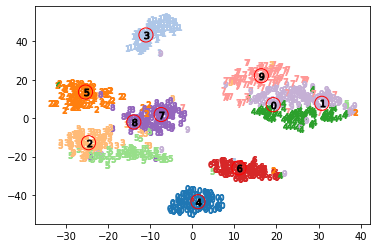

In [95]:
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)
#drawpoints_with_centers(mus_g.view(-1,latent_dim).cpu().detach().numpy()[0:take_latent_max*batch_size],data_labels,mus_g.view(-1,latent_dim).cpu().detach().numpy()[take_latent_max*batch_size:],center_labels)

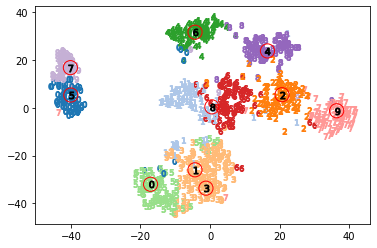

In [305]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

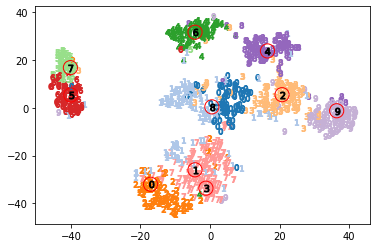

In [306]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

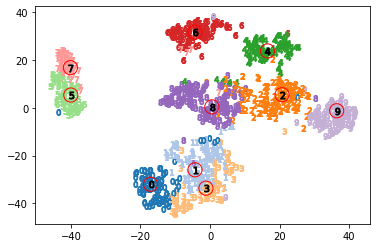

In [307]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [308]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [309]:
#optimizer.param_groups[0]['lr']=0.002,optimizer_clustering.param_groups[0]['lr']=0.002
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0018000000000000002, 0.0018000000000000002, 1.1600000000000001)

In [310]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [311]:
correspond_matrix

tensor([[ 0.,  0.,  1.,  1., 87.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 79.,  0., 51.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  0., 94.],
        [ 1.,  0., 92.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
        [ 2., 64.,  0., 29.,  0.,  0.,  3.,  0.,  0.,  1.],
        [ 0.,  0., 17.,  1.,  6.,  0.,  1.,  0., 61.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  1., 92.,  3.,  4.,  0.],
        [74.,  3.,  0., 29.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 1.,  6., 15.,  1.,  0.,  0.,  0.,  0., 68.,  0.],
        [12., 60.,  4., 16.,  0.,  0.,  0.,  2.,  3.,  1.]])

In [312]:
correspond_matrix.sum()

tensor(1000.)

In [313]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([74., 64., 92., 29., 87., 79., 92., 51., 68., 94.]),
indices=tensor([7, 4, 3, 4, 0, 1, 6, 1, 8, 2]))

In [314]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.7300)

In [315]:
log_N_k_g.exp().squeeze()

tensor([ 6.8678, 10.0106, 10.9951,  8.0703,  9.4880,  4.6371,  7.5124,  3.6691,
        10.4076,  7.0346], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [316]:

log_N_k_g.exp().squeeze().sum()

tensor(78.6925, device='cuda:0', grad_fn=<SumBackward0>)